In [2]:
import pandas as pd
import os

### Import df of 179 stimuli

We had initially taken 180 stimuli (in the initial_data_filtering notebook). Then, in the course of the SHAP map generation process, we discovered that one row was essentially duplicated. We removed this row and now have a jan8_preliminary_sampled_stimuli.pickle file with 179 rows. We begin by loading it

In [3]:
df = pd.read_pickle("jan8_preliminary_sampled_stimuli.pickle")
df

,img_path,caption,foil,linguistic_phenomena,clip_pred_caption,clip_pred_foil,clip_pred_diff,performance_group
468,../VALSE_data/images/coco2017/000000122672.jpg,A man is riding a surfboard through a wave.,A man is riding a surfboard against a wave.,relations,31.702688,32.111187,-0.408499,low_perf
274,../VALSE_data/images/coco2017/000000427649.jpg,The boat sits in the lake below the mountain.,The boat sits in the lake on the mountain.,relations,27.193933,27.211042,-0.017109,low_perf
243,../VALSE_data/images/coco2017/000000451150.jpg,Half a dozen donuts are sitting in a box.,Half a dozen donuts are sitting near a box.,relations,30.128731,30.556664,-0.427933,low_perf
376,../VALSE_data/images/coco2017/000000546659.jpg,A locomotive train carrying carts down a track.,A locomotive train carrying carts up a track.,relations,29.779469,29.801533,-0.022064,low_perf
520,../VALSE_data/images/coco2017/000000229858.jpg,An adult and baby moose step out of a busy thi...,An adult and baby moose step inside of a busy ...,relations,32.175686,33.472778,-1.297092,low_perf
...,...,...,...,...,...,...,...,...
1412,../VALSE_data/images/swig/packaging_189.jpg,A young buck packages up a broom.,A young buck heaves up a broom.,actions,27.694311,22.859179,4.835133,high_perf
1550,../VALSE_data/images/swig/chasing_258.jpg,A hunter chases after a American bison.,A hunter forags after a American bison.,actions,37.372082,35.013138,2.358944,high_perf
1783,../VALSE_data/images/swig/tugging_29.jpg,A person tugs a power cord.,A power cord tugs on a person.,actions,24.806143,22.592257,2.213886,high_perf
1206,../VALSE_data/images/swig/coaching_90.jpg,A woman coaches people.,A woman reads people.,actions,28.184359,18.201620,9.982738,high_perf


# Filter "existence" phenomenon stimuli based on google form survey

We asked 5 people in a google form to go through all 60 "existence" piece stimuli and say whether they could tell the caption from the foil in a BLURRED version of the image. They could answer "I can tell", "I can't tell", and "unsure".

We import the results of the survey now as a CSV. They are originally in this Google Sheet: https://docs.google.com/spreadsheets/d/1iNykt08lXokgdEG9EopyJ9ypshblE5_k7V1Bmzw2bfQ/edit#gid=1122696918

In that Google Sheet we also record manually removed and edited files

In [5]:
gform_df = pd.read_csv("google_form_results_jan15.csv")
gform_df.head(1)

,Nr,Filename,% can't tell,% can tell,% unsure
0,1,v7w_2389519.jpg,100,0,0


We want to rank them as follows: 1) Those where most CAN'T tell the right caption, 2) those where only a minority CAN tell (so unsure + can't tell is majority) 3) Those where majority CAN tell. We then want to sample from 1) and then from 2) to fill up our total

First we filter to those where only a minority CAN tell

### Remove those where 50%+ CAN tell

In [6]:
filtered_gform = gform_df[gform_df['% can tell']<50]
len(filtered_gform) # see how many are now left

40

There are some specific files to REMOVE as well based on feedback from our users (this is reflected in the Google Sheet). 



In [12]:
filtered_gform = filtered_gform[filtered_gform['Filename'] != "v7w_2401335.jpg"] # the mention of a "wall sconce" was seen as confusing. Uncommon word. I agree

In [16]:
most_cant_tell_df = filtered_gform[filtered_gform["% can't tell"]>50]
len(most_cant_tell_df)


26

### Start building final list, beginning with those where majority CAN'T Tell

We check through the files to ensure there are no disqualifiable ones.

In [17]:
most_cant_tell_df

,Nr,Filename,% can't tell,% can tell,% unsure
0,1,v7w_2389519.jpg,100,0,0
3,4,v7w_2370812.jpg,100,0,0
7,8,v7w_2363335.jpg,80,20,0
8,9,v7w_2411632.jpg,60,40,0
12,13,v7w_2335370.jpg,80,20,0
20,21,v7w_2390850.jpg,100,0,0
21,22,v7w_2345325.jpg,80,20,0
22,23,v7w_2342550.jpg,80,0,20
23,24,v7w_2336798.jpg,60,20,20
24,25,v7w_2394557.jpg,80,20,0


In [21]:
len(most_cant_tell_df)

26

All files have been checked, none are disqualified. Some intended caption edits have been recorded in the Google Sheet.

### Sample more files to get to 33 total, this time from those where minority can't tell but also a minority CAN tell

In [18]:
minority_can_tell_df = filtered_gform[filtered_gform["% can't tell"]<50]
len(minority_can_tell_df)


13

In [19]:
minority_can_tell_df

,Nr,Filename,% can't tell,% can tell,% unsure
1,2,v7w_2316446.jpg,40,0,60
2,3,v7w_2345066.jpg,40,40,20
4,5,v7w_2349587.jpg,40,40,20
9,10,v7w_2323857.jpg,40,20,40
10,11,v7w_2408510.jpg,40,40,20
11,12,v7w_2359039.jpg,40,20,40
17,18,v7w_2362476.jpg,40,20,40
19,20,v7w_2403284.jpg,20,40,40
32,33,v7w_150392.jpg,40,40,20
36,37,v7w_2318073.jpg,40,40,20


In [20]:
# sort by % can tell ascending and can't tell descending
minority_can_tell_df = minority_can_tell_df.sort_values(by=["% can tell", "% can't tell"], ascending=[True, False])
minority_can_tell_df



,Nr,Filename,% can't tell,% can tell,% unsure
1,2,v7w_2316446.jpg,40,0,60
9,10,v7w_2323857.jpg,40,20,40
11,12,v7w_2359039.jpg,40,20,40
17,18,v7w_2362476.jpg,40,20,40
2,3,v7w_2345066.jpg,40,40,20
4,5,v7w_2349587.jpg,40,40,20
10,11,v7w_2408510.jpg,40,40,20
32,33,v7w_150392.jpg,40,40,20
36,37,v7w_2318073.jpg,40,40,20
38,39,v7w_2373845.jpg,40,40,20


Now we do a visual inspection. If any are marked for removal, we record this below and the reasons given in the Google Sheet.

In [22]:
numbers_to_remove = [] #NONE

**Create final 33 rows**

In [27]:
# concatenated_existence_df = pd.concat([most_cant_tell_df, minority_can_tell_df.head(7)], ignore_index=True)
concatenated_existence_df

,Nr,Filename,% can't tell,% can tell,% unsure
0,1,v7w_2389519.jpg,100,0,0
1,4,v7w_2370812.jpg,100,0,0
2,8,v7w_2363335.jpg,80,20,0
3,9,v7w_2411632.jpg,60,40,0
4,13,v7w_2335370.jpg,80,20,0
5,21,v7w_2390850.jpg,100,0,0
6,22,v7w_2345325.jpg,80,20,0
7,23,v7w_2342550.jpg,80,0,20
8,24,v7w_2336798.jpg,60,20,20
9,25,v7w_2394557.jpg,80,20,0


### Create existence stimuli DF

In [33]:
# existence_stimuli = df[df["linguistic_phenomena"]=="existence"]
# existence_stimuli = existence_stimuli[existence_stimuli['img_path'].apply(lambda filepath: os.path.basename(filepath) in list(concatenated_existence_df['Filename']))]
# len(existence_stimuli)

33

In [34]:
# existence_stimuli

,img_path,caption,foil,linguistic_phenomena,clip_pred_caption,clip_pred_foil,clip_pred_diff,performance_group
844,../VALSE_data/images/v7w/v7w_2389519.jpg,There are bikes on the rack.,There are no bikes on the rack.,existence,23.316957,25.163563,-1.846605,low_perf
694,../VALSE_data/images/v7w/v7w_2316446.jpg,There are no people in the photo.,There are people in the photo.,existence,22.169107,22.317053,-0.147945,low_perf
761,../VALSE_data/images/v7w/v7w_2345066.jpg,There are no birds in the sky.,There are birds in the sky.,existence,21.893782,22.335999,-0.442217,low_perf
582,../VALSE_data/images/v7w/v7w_2370812.jpg,There are no people.,There are people.,existence,15.981781,16.098076,-0.116295,low_perf
769,../VALSE_data/images/v7w/v7w_2349587.jpg,There are no people.,There are people.,existence,16.677542,17.384785,-0.707243,low_perf
983,../VALSE_data/images/v7w/v7w_2363335.jpg,There is a mast on the closest boat.,There is no mast on the closest boat.,existence,24.548651,24.919718,-0.371067,low_perf
675,../VALSE_data/images/v7w/v7w_2411632.jpg,There are no people in the photo.,There are people in the photo.,existence,19.605886,19.617453,-0.011566,low_perf
904,../VALSE_data/images/v7w/v7w_2323857.jpg,There are kinds of fruit.,There are no kinds of fruit.,existence,24.527332,24.772640,-0.245308,low_perf
875,../VALSE_data/images/v7w/v7w_2408510.jpg,There are dials on the microwave.,There are no dials on the microwave.,existence,28.710060,28.735344,-0.025284,low_perf
953,../VALSE_data/images/v7w/v7w_2359039.jpg,There are zebras facing right.,There are no zebras facing right.,existence,29.596403,30.271812,-0.675409,low_perf


### On second thought, existence selection will me made on Google Sheets directly for more transparency: https://docs.google.com/spreadsheets/d/1vyM7akxqEusa3h6tDejskvQlCTmXUV8j66MEd6MfbAg/edit#gid=1817029700

# Manually approve / reject relations and actions pieces -- FIRST SET

In [35]:
stimuli_other_than_existence = df[df["linguistic_phenomena"]!="existence"]
stimuli_other_than_existence

,img_path,caption,foil,linguistic_phenomena,clip_pred_caption,clip_pred_foil,clip_pred_diff,performance_group
468,../VALSE_data/images/coco2017/000000122672.jpg,A man is riding a surfboard through a wave.,A man is riding a surfboard against a wave.,relations,31.702688,32.111187,-0.408499,low_perf
274,../VALSE_data/images/coco2017/000000427649.jpg,The boat sits in the lake below the mountain.,The boat sits in the lake on the mountain.,relations,27.193933,27.211042,-0.017109,low_perf
243,../VALSE_data/images/coco2017/000000451150.jpg,Half a dozen donuts are sitting in a box.,Half a dozen donuts are sitting near a box.,relations,30.128731,30.556664,-0.427933,low_perf
376,../VALSE_data/images/coco2017/000000546659.jpg,A locomotive train carrying carts down a track.,A locomotive train carrying carts up a track.,relations,29.779469,29.801533,-0.022064,low_perf
520,../VALSE_data/images/coco2017/000000229858.jpg,An adult and baby moose step out of a busy thi...,An adult and baby moose step inside of a busy ...,relations,32.175686,33.472778,-1.297092,low_perf
...,...,...,...,...,...,...,...,...
1412,../VALSE_data/images/swig/packaging_189.jpg,A young buck packages up a broom.,A young buck heaves up a broom.,actions,27.694311,22.859179,4.835133,high_perf
1550,../VALSE_data/images/swig/chasing_258.jpg,A hunter chases after a American bison.,A hunter forags after a American bison.,actions,37.372082,35.013138,2.358944,high_perf
1783,../VALSE_data/images/swig/tugging_29.jpg,A person tugs a power cord.,A power cord tugs on a person.,actions,24.806143,22.592257,2.213886,high_perf
1206,../VALSE_data/images/swig/coaching_90.jpg,A woman coaches people.,A woman reads people.,actions,28.184359,18.201620,9.982738,high_perf


Then within Jupyter create a simple interface going through this new dataframe, loading the image and the caption and foil, and having accept / reject / unsure buttons plus a box underneath that needs to be filled in for anything other than accept. Then that note becomes "reason" and the choice is recorded in the appropriate column of selection_df

In [61]:
selection_df = stimuli_other_than_existence.copy().reset_index()

# Add new columns for approval status and notes
selection_df['Approval'] = ''
selection_df['Notes'] = ''

selection_df.head(1)

,index,img_path,caption,foil,linguistic_phenomena,clip_pred_caption,clip_pred_foil,clip_pred_diff,performance_group,Approval,Notes
0,468,../VALSE_data/images/coco2017/000000122672.jpg,A man is riding a surfboard through a wave.,A man is riding a surfboard against a wave.,relations,31.702688,32.111187,-0.408499,low_perf,,


In [89]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from PIL import Image
import io
import os

current_index = 0
dataframe_in_question = selection_df.copy()

def load_picture():
    clear_output(wait=True) # clear previous output
    note_text.value = ''

    global current_index
    global dataframe_in_question

    # keep loading new ones until reach one where approval is not filled in
    while dataframe_in_question.iloc[current_index]['Approval'] != "":
        current_index += 1

    if current_index < len(dataframe_in_question):
    
        # display image
        img_path = dataframe_in_question.iloc[current_index]['img_path']
        if os.path.exists(img_path):
            img = Image.open(img_path)
            plt.imshow(img)
            plt.axis('off')
            plt.show()
        else:
            print("Image not found.")

        # caption / foil
        print(f"Caption: {dataframe_in_question.iloc[current_index]['caption']}")
        print(f"Foil: {dataframe_in_question.iloc[current_index]['foil']}")
        
        # load buttons and text field
        display(approve_button, reject_button, unsure_button, note_text)

# this handles button clicks
def on_button_clicked(button):

    global current_index
    global dataframe_in_question
    
    # save the approval status to the dataframe
    dataframe_in_question.at[current_index, 'Approval'] = button.description
    
    # Record the note if not 'Approve'
    if button.description != 'Approve':
        dataframe_in_question.at[current_index, 'Notes'] = note_text.value
    
    #  to the next entry
    current_index += 1
        
    if current_index < len(dataframe_in_question):
        load_picture()
    else:
        print("Review complete.")


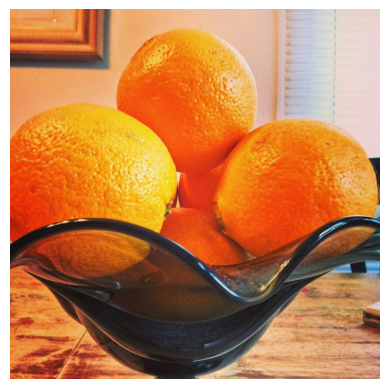

Caption: A group of oranges are sitting in the bowl
Foil: A group of oranges are sitting near the bowl


Button(description='Approve', style=ButtonStyle())

Button(description='Reject', style=ButtonStyle())

Button(description='Unsure', style=ButtonStyle())

Textarea(value='', placeholder='Enter notes here...')

Review complete.


In [108]:

# Create buttons and text area
approve_button = widgets.Button(description='Approve')
reject_button = widgets.Button(description='Reject')
unsure_button = widgets.Button(description='Unsure')
note_text = widgets.Textarea(placeholder='Enter notes here...')

# Bind the button click events
approve_button.on_click(on_button_clicked)
reject_button.on_click(on_button_clicked)
unsure_button.on_click(on_button_clicked)

concatenated_df = pd.concat([top_rows, df2], ignore_index=True)

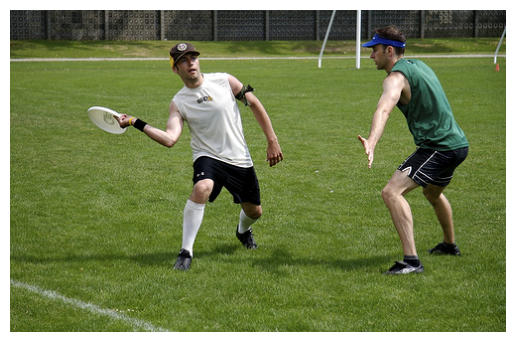

Caption: The player tries to block the other player from throwing a Frisbee.
Foil: The player tries to block the other player into throwing a frisbee.


Button(description='Approve', style=ButtonStyle())

Button(description='Reject', style=ButtonStyle())

Button(description='Unsure', style=ButtonStyle())

Textarea(value='', placeholder='Enter notes here...')

In [76]:
current_index = 0
load_picture()

In [85]:
from collections import Counter
Counter(selection_df['Approval'])

Counter({'Reject': 61, 'Approve': 50, 'Unsure': 9})

In [99]:
selection_df.to_pickle("jan16_action_relation_selection.pickle")

In [100]:
selection_df = pd.read_pickle("jan16_action_relation_selection.pickle")
selection_df

,Unnamed: 0,index,img_path,caption,foil,linguistic_phenomena,clip_pred_caption,clip_pred_foil,clip_pred_diff,performance_group,Approval,Notes
0,0,468.0,../VALSE_data/images/coco2017/000000122672.jpg,A man is riding a surfboard through a wave.,A man is riding a surfboard against a wave.,relations,31.702688,32.111187,-0.408499,low_perf,Reject,"""Against a wave"" is not clearly distinct from ..."
1,1,274.0,../VALSE_data/images/coco2017/000000427649.jpg,The boat sits in the lake below the mountain.,The boat sits in the lake on the mountain.,relations,27.193933,27.211042,-0.017109,low_perf,Approve,NaN
2,2,243.0,../VALSE_data/images/coco2017/000000451150.jpg,Half a dozen donuts are sitting in a box.,Half a dozen donuts are sitting near a box.,relations,30.128731,30.556664,-0.427933,low_perf,Approve,NaN
3,3,376.0,../VALSE_data/images/coco2017/000000546659.jpg,A locomotive train carrying carts down a track.,A locomotive train carrying carts up a track.,relations,29.779469,29.801533,-0.022064,low_perf,Reject,"""down a track"" vs ""up the track"" ambiguous whe..."
4,4,520.0,../VALSE_data/images/coco2017/000000229858.jpg,An adult and baby moose step out of a busy thi...,An adult and baby moose step inside of a busy ...,relations,32.175686,33.472778,-1.297092,low_perf,Approve,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
115,115,1550.0,../VALSE_data/images/swig/chasing_258.jpg,A hunter chases after a American bison.,A hunter forags after a American bison.,actions,37.372082,35.013138,2.358944,high_perf,Reject,Foraging after a bison is semantically almost ...
116,116,1783.0,../VALSE_data/images/swig/tugging_29.jpg,A person tugs a power cord.,A power cord tugs on a person.,actions,24.806143,22.592257,2.213886,high_perf,Reject,A power cord can't tug.
117,117,1206.0,../VALSE_data/images/swig/coaching_90.jpg,A woman coaches people.,A woman reads people.,actions,28.184359,18.201620,9.982738,high_perf,Unsure,"Unclear what ""reading people"" would mean in th..."
118,118,2506.0,../VALSE_data/images/swig/leading_42.jpg,A woman leads a parade.,A parade leads to a woman.,actions,28.277996,25.923393,2.354603,high_perf,Reject,Foil is highly implausible/confusing.


In [86]:
approved_action_relation = selection_df[selection_df['Approval'] == "Approve"]

In [88]:
approved_action_relation.groupby("linguistic_phenomena").count()

,Unnamed: 0,index,img_path,caption,foil,clip_pred_caption,clip_pred_foil,clip_pred_diff,performance_group,Approval,Notes
linguistic_phenomena,,,,,,,,,,,
actions,20,20,20,20,20,20,20,20,20,20,0
relations,30,30,30,30,30,30,30,30,30,30,0


# We need 13 more actions and 3 more relations examples

For this purpose we sampled 45 more samples and 45 more relations ones. Now we manually validate those and then merge

In [111]:
selection_df_2 = pd.read_pickle("jan16_second_set_of_sampled_stimuli.pickle")

selection_df_2['Approval'] = ''
selection_df_2['Notes'] = ''

Now filter those manually!

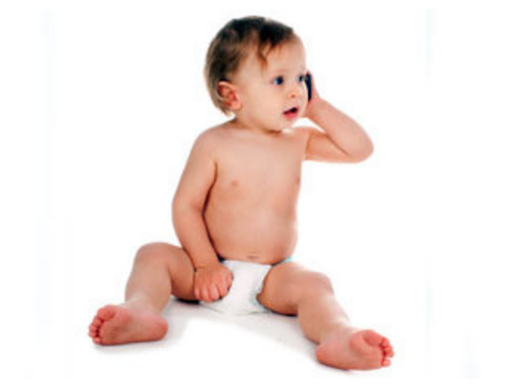

Caption: A baby speaks on a telephone.
Foil: A baby sits on a telephone.


Button(description='Approve', style=ButtonStyle())

Button(description='Reject', style=ButtonStyle())

Button(description='Unsure', style=ButtonStyle())

Textarea(value='', placeholder='Enter notes here...')

In [112]:
dataframe_in_question = selection_df_2.copy() # load temp save so not to start over entirely
dataframe_in_question = dataframe_in_question.reset_index()
current_index = 0
load_picture()

In [145]:
#dataframe_in_question.to_pickle("temp_save.pickle")

In [148]:
dataframe_in_question.head(11)

,index,img_path,caption,foil,linguistic_phenomena,clip_pred_caption,clip_pred_foil,clip_pred_diff,performance_group,Approval,Notes
0,1196,../VALSE_data/images/swig/speaking_84.jpg,A baby speaks on a telephone.,A baby sits on a telephone.,actions,28.024435,28.106859,-0.082424,low_perf,Approve,
1,1974,../VALSE_data/images/swig/kicking_154.jpg,A soccer player kicks a soccer ball.,A soccer ball kicks a soccer player.,actions,25.842213,26.002712,-0.160500,low_perf,Reject,Impossible foil
2,1635,../VALSE_data/images/swig/juggling_131.jpg,A ballplayer juggles a baseball.,A ballplayer disciplines a baseball.,actions,28.437281,28.478926,-0.041645,low_perf,Unsure,Implausible foil
3,1684,../VALSE_data/images/swig/pulling_192.jpg,A truck pulls a boat.,A truck punts a boat.,actions,26.245920,28.028925,-1.783005,low_perf,Unsure,Implausible foil
4,1042,../VALSE_data/images/swig/displaying_251.jpg,A man displays a certificate.,A man carries a certificate.,actions,27.329451,28.549372,-1.219921,low_perf,Unsure,Both are correct
5,1461,../VALSE_data/images/swig/ignoring_131.jpg,A woman ignores a female child.,A woman trains a female child.,actions,21.685972,21.869637,-0.183664,low_perf,Unsure,Neither appear correct
6,1613,../VALSE_data/images/swig/peeing_49.jpg,A male child pees a toilet.,A male child stitches a toilet.,actions,25.536077,28.393578,-2.857500,low_perf,Reject,Implausible foil
7,1604,../VALSE_data/images/swig/shopping_215.jpg,A woman shops at a grocery store.,A woman winks at a grocery store.,actions,28.244438,28.065762,0.178677,low_perf,Approve,
8,1489,../VALSE_data/images/swig/tripping_125.jpg,A man trips across a wire.,A man claws across a wire.,actions,27.444792,27.190014,0.254778,low_perf,Approve,
9,1961,../VALSE_data/images/swig/tripping_3.jpg,A person trips across a rug.,A rug trips over a person.,actions,31.175245,31.609753,-0.434507,low_perf,Unsure,Implausible foil


In [204]:
load_picture()


IndexError: single positional indexer is out-of-bounds

In [206]:
dataframe_in_question.tail(15)

,index,img_path,caption,foil,linguistic_phenomena,clip_pred_caption,clip_pred_foil,clip_pred_diff,performance_group,Approval,Notes
75,44,../VALSE_data/images/coco2017/000000367195.jpg,A picture of a dog laying under a table on the...,A picture of a dog laying at a table on the rug.,relations,29.292770,28.470411,0.822359,high_perf,Unsure,Foil is not incorrect.
76,129,../VALSE_data/images/coco2017/000000245026.jpg,A woman wearing glasses poses behind her birth...,A woman wearing glasses poses on her birthday ...,relations,31.977247,30.899172,1.078075,high_perf,Unsure,Highly implausible foil
77,494,../VALSE_data/images/coco2017/000000217400.jpg,A train is pulling into a subway stop.,A train is pulling past a subway stop.,relations,26.769211,25.926617,0.842594,high_perf,Unsure,Both could be correct.
78,85,../VALSE_data/images/coco2017/000000517832.jpg,The black dog sits alertly on the vintage chair.,The black dog sits alertly behind the vintage ...,relations,30.919231,30.097469,0.821762,high_perf,Approve,
79,26,../VALSE_data/images/coco2017/000000194471.jpg,A man on a skateboard is coming up a ramp.,A man on a skateboard is coming down a ramp.,relations,27.645075,27.130201,0.514874,high_perf,Unsure,Both could be correct.
80,273,../VALSE_data/images/coco2017/000000121586.jpg,A cat is on the television screen in an office.,A cat is below the television screen in an off...,relations,27.276440,25.306311,1.970129,high_perf,Unsure,Both could be correct
81,281,../VALSE_data/images/coco2017/000000082696.jpg,A bird is walking right through a dining room.,A bird is walking right by a dining room.,relations,32.540516,30.057785,2.482731,high_perf,Approve,
82,61,../VALSE_data/images/coco2017/000000118209.jpg,there are two horses standing behind a fence,There are two horses standing on a fence,relations,31.741583,29.959080,1.782503,high_perf,Approve,
83,34,../VALSE_data/images/coco2017/000000393226.jpg,The man is walking behind the concession bus.,The man is walking down the concession bus.,relations,26.424616,25.223183,1.201433,high_perf,Unsure,Invalid foil
84,38,../VALSE_data/images/coco2017/000000089880.jpg,Two dogs are playing together on the grass,Two dogs are playing together under the grass,relations,29.409924,28.666496,0.743427,high_perf,Approve,


In [208]:
dataframe_in_question.to_pickle("jan17_action_relations_stimuli_PART_2.pickle")

Now both will be loaded into GOOGLE SHEETS where they will be cleaned and merged.

In [209]:
dataframe_in_question.to_csv("jan17_action_relations_stimuli_PART_2.csv")

### Temporary (Delete later)

files to get captions, foils for:

In [4]:
list_of_filenames = "v7w_2389519.jpg	v7w_2316446.jpg	v7w_2345066.jpg	v7w_2370812.jpg	v7w_2349587.jpg	v7w_2401335.jpg	v7w_2361201.jpg	v7w_2363335.jpg	v7w_2411632.jpg	v7w_2323857.jpg	v7w_2408510.jpg	v7w_2359039.jpg	v7w_2335370.jpg	v7w_2380468.jpg	v7w_2359029.jpg	v7w_2367703.jpg	v7w_2406996.jpg	v7w_2362476.jpg	v7w_2374842.jpg	v7w_2403284.jpg	v7w_2390850.jpg	v7w_2345325.jpg	v7w_2342550.jpg	v7w_2336798.jpg	v7w_2394557.jpg	v7w_2363617.jpg	v7w_2364948.jpg	v7w_1591818.jpg	v7w_713731.jpg	v7w_2345780.jpg	v7w_2352298.jpg	v7w_2328270.jpg	v7w_150392.jpg	v7w_2360186.jpg	v7w_2411942.jpg	v7w_2373121.jpg	v7w_2318073.jpg	v7w_2359944.jpg	v7w_2373845.jpg	v7w_2325309.jpg	v7w_2410671.jpg	v7w_2367084.jpg	v7w_2361437.jpg	v7w_2393355.jpg	v7w_2362253.jpg	v7w_1159443.jpg	v7w_2339363.jpg	v7w_2331050.jpg	v7w_2324297.jpg	v7w_2402139.jpg	v7w_2360434.jpg	v7w_2361951.jpg	v7w_2401288.jpg	v7w_2407816.jpg	v7w_2385384.jpg	v7w_2346628.jpg	v7w_2370926.jpg	v7w_2401445.jpg	v7w_2417412.jpg	v7w_2416322.jpg"
filenames = list_of_filenames.split()
filenames

['v7w_2389519.jpg',
 'v7w_2316446.jpg',
 'v7w_2345066.jpg',
 'v7w_2370812.jpg',
 'v7w_2349587.jpg',
 'v7w_2401335.jpg',
 'v7w_2361201.jpg',
 'v7w_2363335.jpg',
 'v7w_2411632.jpg',
 'v7w_2323857.jpg',
 'v7w_2408510.jpg',
 'v7w_2359039.jpg',
 'v7w_2335370.jpg',
 'v7w_2380468.jpg',
 'v7w_2359029.jpg',
 'v7w_2367703.jpg',
 'v7w_2406996.jpg',
 'v7w_2362476.jpg',
 'v7w_2374842.jpg',
 'v7w_2403284.jpg',
 'v7w_2390850.jpg',
 'v7w_2345325.jpg',
 'v7w_2342550.jpg',
 'v7w_2336798.jpg',
 'v7w_2394557.jpg',
 'v7w_2363617.jpg',
 'v7w_2364948.jpg',
 'v7w_1591818.jpg',
 'v7w_713731.jpg',
 'v7w_2345780.jpg',
 'v7w_2352298.jpg',
 'v7w_2328270.jpg',
 'v7w_150392.jpg',
 'v7w_2360186.jpg',
 'v7w_2411942.jpg',
 'v7w_2373121.jpg',
 'v7w_2318073.jpg',
 'v7w_2359944.jpg',
 'v7w_2373845.jpg',
 'v7w_2325309.jpg',
 'v7w_2410671.jpg',
 'v7w_2367084.jpg',
 'v7w_2361437.jpg',
 'v7w_2393355.jpg',
 'v7w_2362253.jpg',
 'v7w_1159443.jpg',
 'v7w_2339363.jpg',
 'v7w_2331050.jpg',
 'v7w_2324297.jpg',
 'v7w_2402139.jpg',
 '

In [15]:
sorted_df = df[df['img_path'].apply(lambda x: x.split('/')[-1]).isin(filenames)].copy() # limit df to only those in filenames
sorted_df['sort_key'] = sorted_df['img_path'].apply(lambda x: filenames.index(x.split('/')[-1])) # get index of each img_path in filenames
sorted_df = sorted_df.sort_values('sort_key').drop('sort_key', axis=1) # sort by that index, then drop the index column
sorted_df.to_csv("sorted_existence.csv")

In [9]:
!pip install openpyxl

DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support pip 21.0 will remove support for this functionality.
     |████████████████████████████████| 173 kB 3.4 MB/s eta 0:00:01
Using legacy 'setup.py install' for openpyxl, since package 'wheel' is not installed.
Using legacy 'setup.py install' for et-xmlfile, since package 'wheel' is not installed.
    Running setup.py install for et-xmlfile ... done
    Running setup.py install for openpyxl ... done
